# Data access, sampling, scope definition, dataset freeze

We are going to start loading the data, knowing that we have a very big dataset we will tackle the reading of the data ina different way, we want to load data safely, incrementally, and intentionally, preserving flexibility for later sampling and feature engineering while keeping computation manageable.

This step does not attempt to clean or engineer features yet. It is strictly about controlled access to the data.

Due to the size of the dataset, a performance-aware loading strategy was implemented using customer-level sampling and chunked data ingestion, allowing efficient experimentation while preserving temporal information.

In [28]:
# We are going to start with the smallest file

import pandas as pd

from AE_Credit_Default_Cleaning_Aggregation import labels_df

labels_path = "train_labels.csv"

labels_df = pd.read_csv(labels_path)
labels_df.head()


,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [14]:
labels_df.shape
labels_df["target"].value_counts(normalize=True)


target
0    0.741066
1    0.258934
Name: proportion, dtype: float64

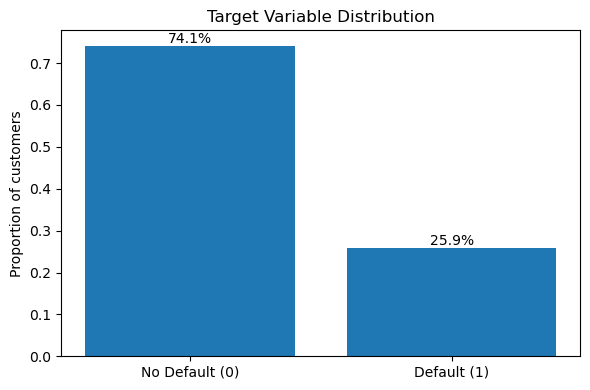

In [34]:
import numpy as np
import matplotlib.pyplot as plt

y = labels_df['target'].values

# Count occurrences of each class
classes, counts = np.unique(y, return_counts=True)

# Convert counts to proportions (optional but recommended)
proportions = counts / counts.sum()

# Create bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(classes, proportions)

# Labeling
plt.xticks(classes, ['No Default (0)', 'Default (1)'])
plt.ylabel('Proportion of customers')
plt.title('Target Variable Distribution')

# Add percentage labels on top of bars
for bar, prop in zip(bars, proportions):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{prop:.1%}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


Now we know that there's a row per customer and there is an imbalance in the data (expected in credit risk)

Now we are going to decide what columns we need, first we will always load customer_ID, then load a subset of features initially and expand later if justified

In [15]:
# Inspect column names without loading full data
sample_iter = pd.read_csv(
    "train_data.csv",
    nrows=5
)

sample_iter.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=190)

Knowing that the dataset is large we will load it in chunks with this we prevent memory spikes, allows customer-based filtering, enables streaming-style processing

In [16]:
CHUNK_SIZE = 200_000  # We can adjust if needed

data_iter = pd.read_csv(
    "train_data.csv",
    chunksize=CHUNK_SIZE
)

This creates an iterator, not a DataFrame. Nothing heavy has loaded yet.

Since we already loaded labels_df, we can preselect a subset of customers

In [17]:
import numpy as np

N_CUSTOMERS = 30_000 # Example: sample 50,000 customers. >> Reduced to 30,000 for less memory usage
rng = np.random.default_rng(42)

sampled_customers = rng.choice(
    labels_df["customer_ID"],
    size=N_CUSTOMERS,
    replace=False
)

sampled_customers = set(sampled_customers)


We filter chunks incrementally, we stream through the dataset and keep only what we need.

In [18]:
filtered_chunks = []

for chunk in data_iter:
    chunk_filtered = chunk[
        chunk["customer_ID"].isin(sampled_customers)
    ]

    if not chunk_filtered.empty:
        filtered_chunks.append(chunk_filtered)

In [19]:
# We assemble the reduced dataset
data_sampled_df = pd.concat(filtered_chunks, ignore_index=True)

data_sampled_df.shape

(361460, 190)

Perform a quick memory sanity check

In [20]:
data_sampled_df.memory_usage(deep=True).sum() / 1e6


636.270413

# Data Sampling & Scope Definition

How do we reduce the data size without destroying the time structure that makes it valuable?
Sample at the customer level, not the row level.
Keep all historical records for each sampled customer.

We're shrinking the population

We defined:
- A representative subset of customers (≈30,000)
- All historical statements for each selected customer
- Labels sourced cleanly from train_labels.csv
- A dataset size that is:
- Big enough to generalize
- Small enough to iterate
- Structured enough for serious modeling

To ensure computational feasibility while preserving the temporal structure of the data, we performed customer-level sampling. A representative subset of customers was selected, and all historical records associated with each sampled customer were retained. This approach reduces dataset size without breaking longitudinal dependencies, enabling reliable feature aggregation and model evaluation in subsequent steps.

In [21]:
# We verify sample integrity

data_sampled_df["customer_ID"].nunique()
labels_df["customer_ID"].nunique()
labels_df.duplicated("customer_ID").sum()

0

In [22]:
# Validate class representation

sample_labels = labels_df[labels_df["customer_ID"].isin(data_sampled_df["customer_ID"].unique())]
sample_labels["target"].value_counts()
sample_labels["target"].value_counts(normalize=True)

target
0    0.737233
1    0.262767
Name: proportion, dtype: float64

In [23]:
# Customers in data
data_customers = set(data_sampled_df["customer_ID"].unique())

# Customers in labels
label_customers = set(sample_labels["customer_ID"].unique())

data_customers == label_customers


True

In [24]:
data_sampled_df = data_sampled_df.sort_values(
    by=["customer_ID", "S_2"]  # S_2 = statement date
).reset_index(drop=True)

sample_labels = sample_labels.sort_values(
    by="customer_ID"
).reset_index(drop=True)


In [25]:
data_sampled_df.to_parquet(
    "amex_step4_data_sampled.parquet",
    index=False
)

sample_labels.to_parquet(
    "amex_step4_labels.parquet",
    index=False
)


The dataset was frozen after customer-level random sampling of 30,000 customers using a fixed random seed. All subsequent preprocessing, feature engineering, and modeling steps were performed on this fixed subset to ensure reproducibility and fair model comparison.

In [26]:
data_sampled_df.shape
sample_labels.shape
data_sampled_df["customer_ID"].nunique()


30000